## Установки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,\
    make_scorer, roc_curve, recall_score, precision_score, precision_recall_curve
from sklearn.utils import shuffle
from scipy import stats as st

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

In [2]:
import warnings
warnings.simplefilter('ignore')

Установка отображения не более двух знаков после запятой

In [3]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [4]:
pd.set_option('display.max_columns', 87)

## предобработка данных

In [5]:
path = '/datasets/final_provider/'

In [6]:
dfs = ['contract', 'personal', 'internet', 'phone']

Функция для ознакомления с данными

In [7]:
def reader(data):
    data = pd.read_csv(path + data + '.csv')
    display(data.head(7))
    display(data.info())
    print('-----')
    
    for i in range(len(data.columns)):
        display((data[data.columns[i]].value_counts()))
        print('=====')
    return data

### Информация о договоре

In [8]:
contract = reader('contract')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

-----


4537-CIBHB    1
3402-XRIUO    1
7707-PYBBH    1
6861-XWTWQ    1
0701-RFGFI    1
             ..
7779-LGOVN    1
4609-KNNWG    1
9830-ECLEN    1
1779-PWPMG    1
9885-CSMWE    1
Name: customerID, Length: 7043, dtype: int64

=====


2014-02-01    366
2019-11-01    237
2019-10-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

=====


No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

=====


Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

=====


Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

=====


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

=====


20.05     61
19.85     45
19.90     44
19.95     44
19.65     43
          ..
87.65      1
35.30      1
114.85     1
56.50      1
97.25      1
Name: MonthlyCharges, Length: 1585, dtype: int64

=====


           11
20.2       11
19.75       9
19.9        8
20.05       8
           ..
1439.35     1
1281        1
3549.25     1
4914.9      1
447.9       1
Name: TotalCharges, Length: 6531, dtype: int64

=====


Пропуски отсуствуют   
Форматы в столбцах __BeginDate, EndDate, MonthlyCharges, TotalCharges__ некорректные  
Есть нечисловые значения в столбце __TotalCharges__

In [9]:
df_contract = contract.copy(deep=True)

# Меняем форматы

In [10]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')

In [11]:
df_contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [12]:
df_contract['EndDate'] = df_contract['EndDate'].replace(to_replace='No', value='2020-02-01')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format="%Y-%m-%d")

In [13]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [14]:
df_contract['TotalCharges'].value_counts().head()

         11
20.2     11
19.75     9
19.9      8
20.05     8
Name: TotalCharges, dtype: int64

In [15]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace(to_replace=' ', value=0)

In [16]:
df_contract['TotalCharges'].value_counts().head()

0        11
20.2     11
19.75     9
19.65     8
19.9      8
Name: TotalCharges, dtype: int64

In [17]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')

In [18]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Форматы корректны

### Персональные данные клиента

In [19]:
personal = reader('personal') 

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

-----


4537-CIBHB    1
3402-XRIUO    1
7707-PYBBH    1
6861-XWTWQ    1
0701-RFGFI    1
             ..
7779-LGOVN    1
4609-KNNWG    1
9830-ECLEN    1
1779-PWPMG    1
9885-CSMWE    1
Name: customerID, Length: 7043, dtype: int64

=====


Male      3555
Female    3488
Name: gender, dtype: int64

=====


0    5901
1    1142
Name: SeniorCitizen, dtype: int64

=====


No     3641
Yes    3402
Name: Partner, dtype: int64

=====


No     4933
Yes    2110
Name: Dependents, dtype: int64

=====


Пропуски отсутствуют, форматы корректны

### Информация об интернет-услугах

In [20]:
internet = reader('internet') 

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

-----


3058-WQDRE    1
9220-CXRSC    1
3165-HDOEW    1
2933-XEUJM    1
6029-CSMJE    1
             ..
2460-FPSYH    1
4881-JVQOD    1
3398-ZOUAA    1
1395-OFUWC    1
9065-ZCPQX    1
Name: customerID, Length: 5517, dtype: int64

=====


Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

=====


No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

=====


No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

=====


No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

=====


No     3473
Yes    2044
Name: TechSupport, dtype: int64

=====


No     2810
Yes    2707
Name: StreamingTV, dtype: int64

=====


No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

=====


Пропуски отсутствуют, форматы корректны

### Информация об услугах телефонии

In [21]:
phone = reader('phone') 

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

-----


4537-CIBHB    1
7856-GANIL    1
2696-NARTR    1
9592-ERDKV    1
4529-CKBCL    1
             ..
6504-VBLFL    1
0856-NAOES    1
2476-YGEFM    1
3452-FLHYD    1
9885-CSMWE    1
Name: customerID, Length: 6361, dtype: int64

=====


No     3390
Yes    2971
Name: MultipleLines, dtype: int64

=====


Пропуски отсутствуют, форматы корректны

### Объединение таблиц

In [22]:
data = df_contract.merge(personal, on='customerID', how='outer')

In [23]:
data = data.merge(internet, on='customerID', how='outer')

In [24]:
data = data.merge(phone, on='customerID', how='outer')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [26]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [27]:
data[data['InternetService'].isna()].head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
11,7469-LKBCI,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,326.80,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
16,8191-XWSZG,2015-10-01,2020-02-01,One year,No,Mailed check,20.65,"1,022.95",Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [28]:
data[data['MultipleLines'].isna()].head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,"1,840.75",Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN


Пропуски в столбцах заменим на постоянное значение __unknown__, так как датасет небольшой и терять данные не хотелось бы

In [29]:
data = data.fillna('unknown')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

## Исследовательский анализ

Функция для построения графиков распределения и боксплот

In [31]:
def distribution(series):
    plt.figure(figsize=(12,8))
    sns.set_style('darkgrid')
  
    plt.subplot(211)
    plt.title('Распределение ' + series.name)
    sns.distplot(series)
    
    plt.subplot(212)
    sns.boxenplot(series)

    plt.show()
    display(series.describe())

In [32]:
data.corr()

,MonthlyCharges,TotalCharges,SeniorCitizen
MonthlyCharges,1.00,0.65,0.22
TotalCharges,0.65,1.00,0.10
SeniorCitizen,0.22,0.10,1.00


Значительные взаимосвязи между данными в числовых столбцах отсутсвуют

### Месячные траты

Распределение месячных трат клиентов

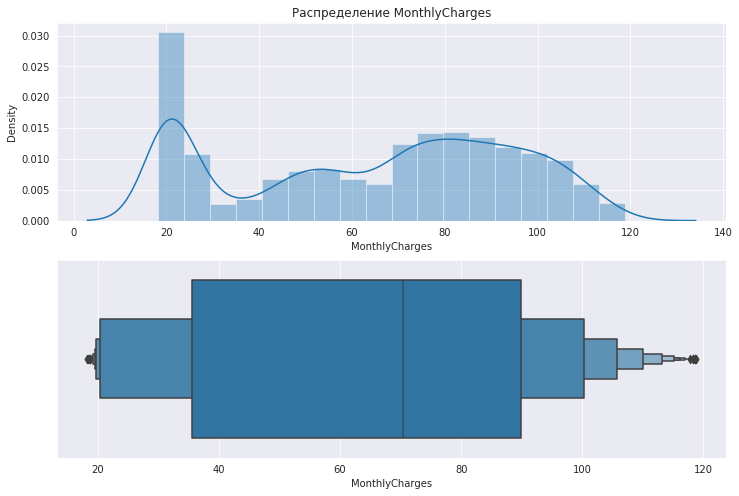

count   7,043.00
mean       64.76
std        30.09
min        18.25
25%        35.50
50%        70.35
75%        89.85
max       118.75
Name: MonthlyCharges, dtype: float64

In [33]:
distribution(data['MonthlyCharges'])

Наиболее популярна абонентская плата с нименьшей стоимостью

Выделим столбец __Год__ для рассмотрения трат в периодах времени

In [34]:
data['year_BeginDate'] = data['BeginDate'].dt.to_period('Y')

In [35]:
temp = data.sort_values(by='year_BeginDate')
temp.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,year_BeginDate
6038,1555-DJEQW,2013-12-01,2019-10-01,Two year,Yes,Bank transfer (automatic),114.20,"7,723.90",Female,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2013
3040,7317-GGVPB,2013-11-01,2019-10-01,Two year,Yes,Credit card (automatic),108.60,"7,690.90",Male,0,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,2013
4610,2889-FPWRM,2013-10-01,2019-10-01,One year,Yes,Bank transfer (automatic),117.80,"8,684.80",Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2013


In [36]:
data.groupby('year_BeginDate', as_index=False)['MonthlyCharges'].mean()

,year_BeginDate,MonthlyCharges
0,2013,100.53
1,2014,76.13
2,2015,70.93
3,2016,66.81
4,2017,66.41
5,2018,62.02
6,2019,57.38
7,2020,38.07


Функция построения барплот по двум-трем столбцам

In [37]:
def draw_barplot(column_1, column_2, column_3=None):
    plt.figure(figsize=(20,8))
    sns.set_style('darkgrid')
    try:
        if column_3 == None:
            plt.title(column_2.name+ ' in order '+ column_1.name)
#         elif column_3 != None:
#             plt.title(column_2.name+ ' / ' + column_3.name +' in order '+ column_1.name)
    except:
        plt.title(column_2.name+ ' / ' + column_3.name +' in order '+ column_1.name)

    sns.barplot(x=column_1, y=column_2, hue=column_3)

    plt.show()

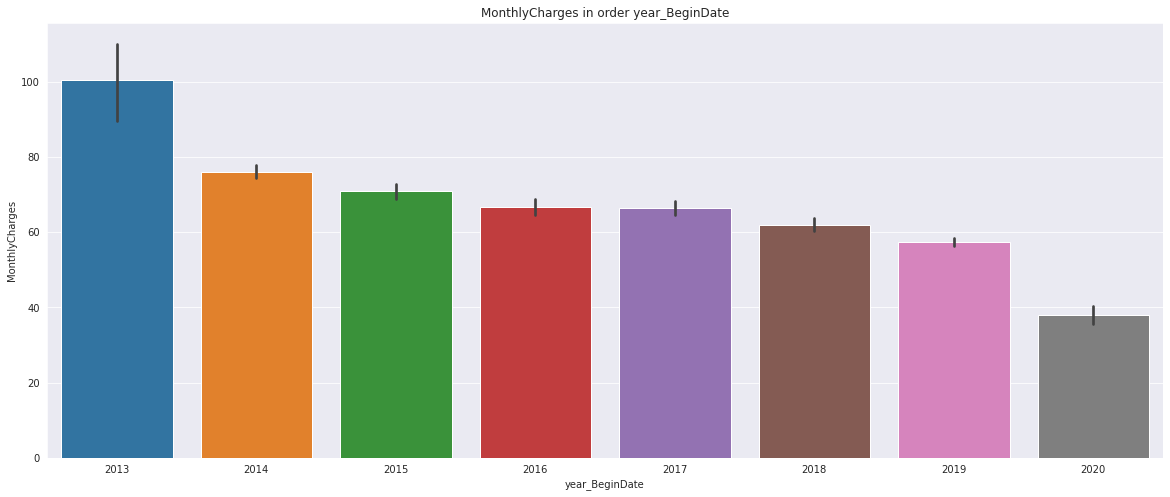

In [38]:
draw_barplot(temp['year_BeginDate'], temp['MonthlyCharges'])

Похоже на тренд снижения абонентской платы, возможно вызвано тем, что в конкрурентной борьбе за клиентов снижается стоимость предоставляемых услуг

In [39]:
df_ttest = data.groupby('year_BeginDate', as_index=False)['MonthlyCharges'].count()
df_ttest

,year_BeginDate,MonthlyCharges
0,2013,8
1,2014,1344
2,2015,852
3,2016,763
4,2017,845
5,2018,1030
6,2019,1957
7,2020,244


Для гипотезы отбросим 2013 и 2020 годы, так как 2020 год имеет данные только за один месяц, в 2013 г. также очень мало данных

__Проверим гипотезу о равенстве двух средних__  
Н0 = средние месячные расходы 2014-2016 гг равны средним месячным расходам 2017-2019  
Н1 = средние месячные расходы 2014-2016 гг НЕ равны средним месячным расходам 2017-2019

Формируем выборки

In [40]:
df_2014_2016 = data.loc[
    (data['year_BeginDate'] <= '2016-01-01') & 
    (data['year_BeginDate'] >= '2014-01-01'), 
    'MonthlyCharges'
]
df_2014_2016.shape

(2959,)

In [41]:
df_2017_2019 = data.loc[
    (data['year_BeginDate'] <= '2019-01-01') & 
    (data['year_BeginDate'] >= '2017-01-01'),
    'MonthlyCharges'
]
df_2017_2019.shape

(3832,)

In [42]:
def exploration(data_1, data_2):
    print(f'Дисперсия выборки - 1: ', np.var(data_1, ddof=1))
    print(f'Дисперсия выборки - 2: ', np.var(data_2, ddof=1))
    print()
    plt.figure(figsize=(10,12))
    
#     plt.title('Распределение месячных трат')
    
    plt.subplot(311)
    sns.distplot(data_1)
    sns.distplot(data_2)
    plt.title('Распределение месячных трат')
    
    plt.subplot(312)
    sns.boxenplot(data_1)
    plt.subplot(313)
    sns.boxenplot(data_2, palette='Oranges')
    
    plt.show()
    
    print(data_1.describe())
    print()
    print(data_2.describe())    

Дисперсия выборки - 1:  986.1049461167622
Дисперсия выборки - 2:  766.5958746999058



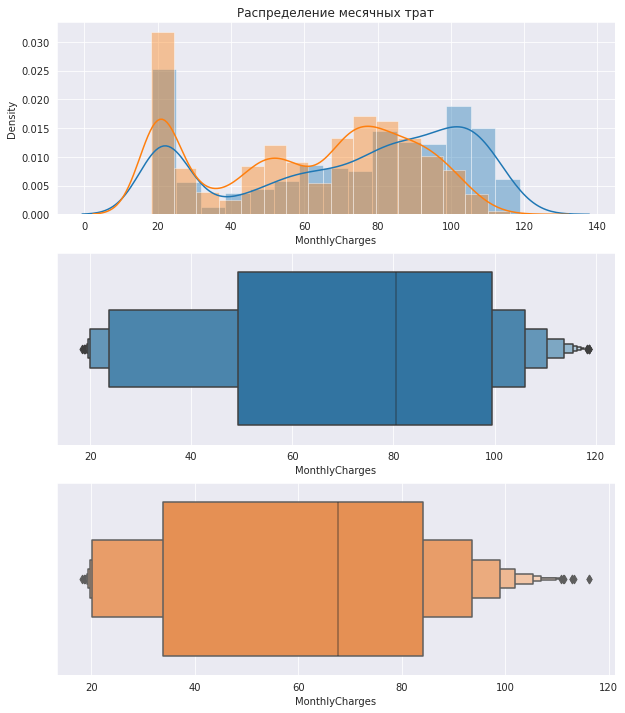

count   2,959.00
mean       72.23
std        31.40
min        18.40
25%        49.17
50%        80.45
75%        99.45
max       118.75
Name: MonthlyCharges, dtype: float64

count   3,832.00
mean       60.62
std        27.69
min        18.25
25%        33.86
50%        67.70
75%        84.05
max       116.25
Name: MonthlyCharges, dtype: float64


In [43]:
exploration(df_2014_2016, df_2017_2019)

На графике распределения видно, что в 2017-2019 гг пик на минимальных месячных тратах выше, чем в 2014-2016 гг.  
Также на графике боксплот видно, что среднее значение месячных трат в 2014-2016 гг превышает значение в 2017-2019 гг

Тест на нормальность распределения данных

In [44]:
alpha = 0.05
stat,p = st.shapiro(df_2014_2016)
print(f'p-value :', p)
if p < alpha:
    print('Отвергаем Н0')
else:
    print('НЕ получилось отвергнуть Н0') 

p-value : 1.786725606937358e-40
Отвергаем Н0


In [45]:
alpha = 0.05
stat,p = st.shapiro(df_2017_2019)
print(f'p-value :', p)
if p < alpha:
    print('Отвергаем Н0')
else:
    print('НЕ получилось отвергнуть Н0') 

p-value : 2.9193250907278914e-41
Отвергаем Н0


Таким образм обе выборки не имеют распределение Гаусса

Проведем тест проверки равенства дисперсий двух выборок  
Н0: медиана дисперсий двух выборок равны  
Н1: медиана дисперсий двух выборок НЕ равны 

Воспользуемся тестом Левена, так как данные не распределены нормальным распределением.  
Поэтому же используем медиану.

In [46]:
alpha = 0.05
result = st.levene(df_2014_2016, df_2017_2019, center='median')
print(f'p-value :', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем Н0 = Дисперсии равны')
else:
    print('НЕ получилось отвергнуть Н0')

p-value : 4.5233505201046054e-08
Отвергаем Н0 = Дисперсии равны


По итогам теста отвергаем нулевую гипотезу о равенстве дисперсий

Устанавливаем уровень значимости = 0.05 и применяем критерий Манна-Уитни, так как данные не распределены нормальным образом

In [47]:
alpha = 0.05
result = st.mannwhitneyu(df_2014_2016, df_2017_2019)
print(f'p-value :', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем Н0')
else:
    print('НЕ получилось отвергнуть Н0')    

p-value : 2.305528775535917e-71
Отвергаем Н0


Тест подтвердил наши наблюдения и нулевая гипотеза была отвергнута, так как p-value много меньше уровня значимости, установленного в 5%, что свидетельствует об очень низкой вероятности того, что среднее значение этих выборок равны, что наглядно видно на графиках выше

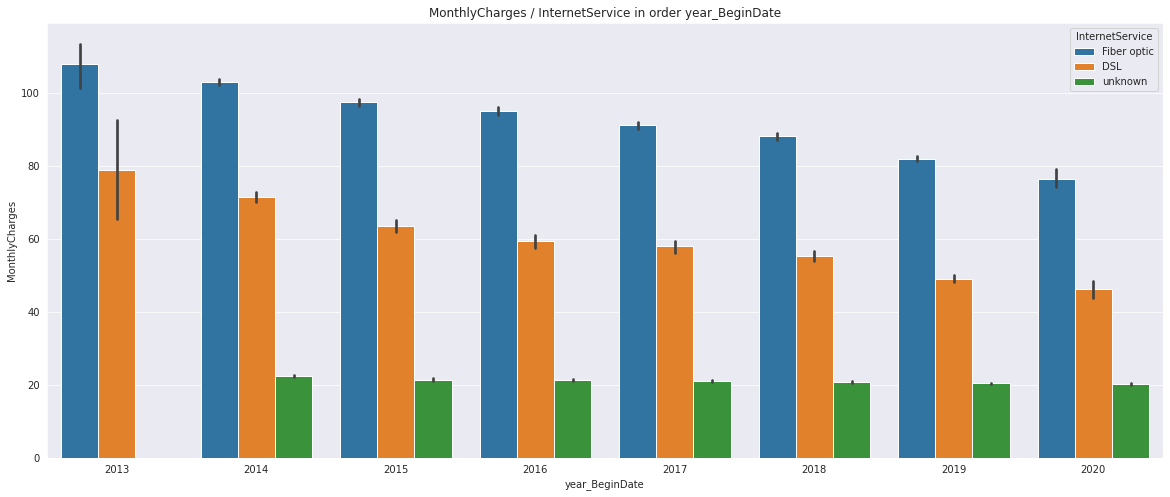

In [48]:
draw_barplot(temp['year_BeginDate'], temp['MonthlyCharges'], temp['InternetService'])

In [49]:
data.groupby(['year_BeginDate', 'InternetService'], as_index=False)['MonthlyCharges'].mean()

,year_BeginDate,InternetService,MonthlyCharges
0,2013,DSL,78.88
1,2013,Fiber optic,107.75
2,2014,DSL,71.43
3,2014,Fiber optic,102.98
4,2014,unknown,22.52
5,2015,DSL,63.51
6,2015,Fiber optic,97.31
7,2015,unknown,21.45
8,2016,DSL,59.30
9,2016,Fiber optic,95.01


Стоимость обоих типов интернет соединения вероятно также имеет плавный тренд снижения стоимости. Возможно, стоимость оптоволоконного подключения выше, обусловлено более высокой скоротью доступа в интернет

In [50]:
for column in data.columns[-8:-2]:
    lenght = len(data[data[column] == 'Yes'])
    print(column, lenght)

OnlineSecurity 2019
OnlineBackup 2429
DeviceProtection 2422
TechSupport 2044
StreamingTV 2707
StreamingMovies 2732


Чаще остальных подключают фильмы и телевидение 

### Общие траты

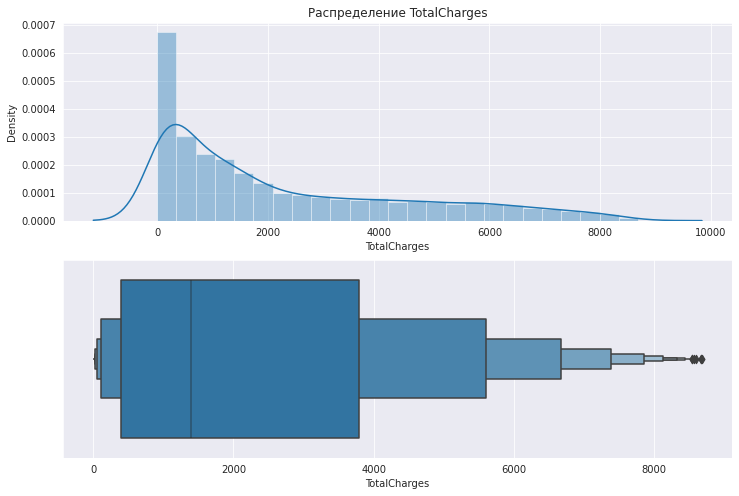

count   7,043.00
mean    2,279.73
std     2,266.79
min         0.00
25%       398.55
50%     1,394.55
75%     3,786.60
max     8,684.80
Name: TotalCharges, dtype: float64

In [51]:
distribution(data['TotalCharges'])

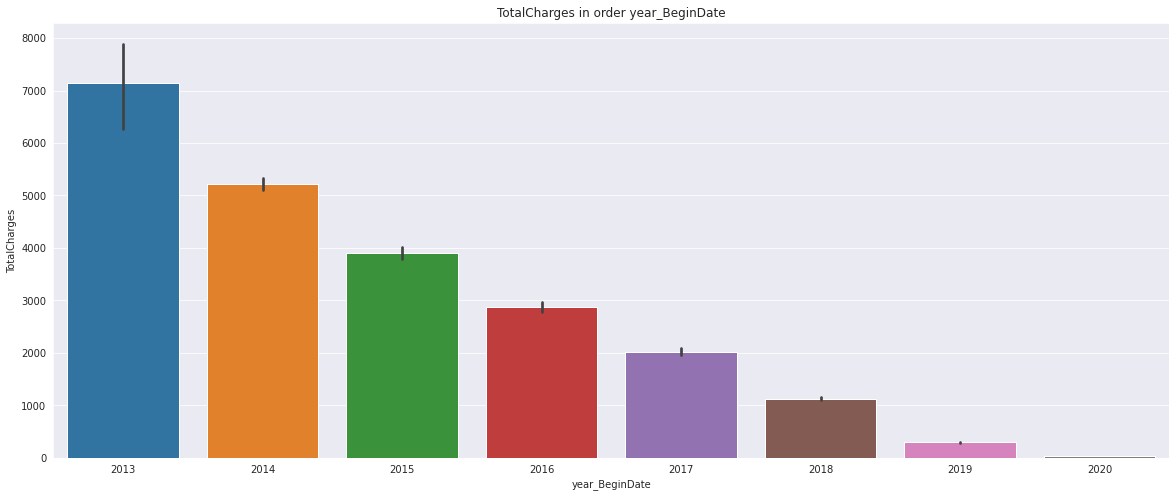

In [52]:
draw_barplot(temp['year_BeginDate'], temp['TotalCharges'])

Ожидаемо, что чем больше общие траты, тем дольше пользователь является клиентом

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

### Вывод:

1. загрузили данные
2. привели к корректным форматам
3. пропуски заполнили меткой _unknown_

## Обучение моделей

Создание признака с количеством дней пользования сервисом

In [54]:
data['time_delta'] = (data['EndDate'] - data['BeginDate']).dt.days

Разметка целевого признака

In [55]:
data['exited'] = data['EndDate'].astype('str').str.replace('2020-02-01', '0')

In [56]:
data.loc[data['exited'] != '0', 'exited'] = 1

In [57]:
data['exited'] = data['exited'].astype('int')

In [58]:
data[['MonthlyCharges', 'TotalCharges', 'time_delta']].corr()

,MonthlyCharges,TotalCharges,time_delta
MonthlyCharges,1.00,0.65,0.25
TotalCharges,0.65,1.00,0.83
time_delta,0.25,0.83,1.00


_time_delta_ довольно сильно коррелируют с _TotalCharges_ (чем больше общие траты, тем больше дней клиент использует сервис)

<Figure size 1080x1080 with 0 Axes>

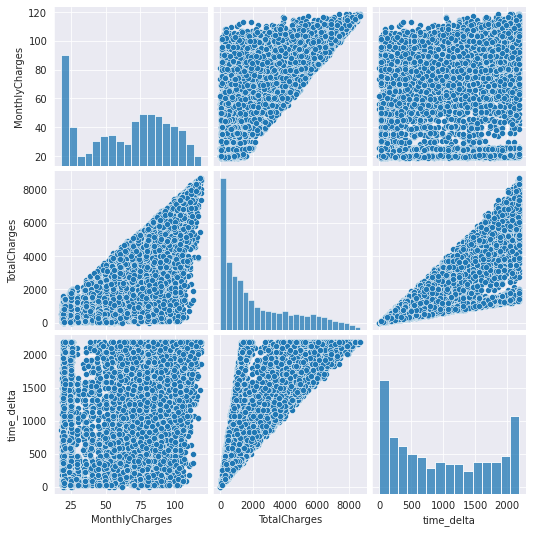

In [59]:
plt.figure(figsize=(15,15))
sns.pairplot(data[['MonthlyCharges', 'TotalCharges', 'time_delta']])
plt.show()

Удаляем следующие столбцы:
- с уникальными значениями, так как не могут быть признаками (_customerID_)
- не используемые по условиям задачи (_BeginDate, EndDate_)
- созданные для удобства анализа (_year_BeginDate_)

In [60]:
data_formatted = data.drop(['customerID', 'BeginDate','EndDate', 'year_BeginDate'], axis=1)

# Кодирование нечисловых переменных

In [61]:
data_ordinal = data_formatted.copy(deep=True)

In [62]:
categorical = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService',
              'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'MultipleLines']

In [63]:
encoder = OrdinalEncoder()
encoder.fit(data_ordinal[categorical])
data_ordinal[categorical] = encoder.transform(data_ordinal[categorical])
data_ordinal.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,time_delta,exited
0,0.00,1.00,2.00,29.85,29.85,0.00,0,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,31,0
1,1.00,0.00,3.00,56.95,"1,889.50",1.00,0,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1036,0
2,0.00,1.00,3.00,53.85,108.15,1.00,0,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,61,1
3,1.00,0.00,0.00,42.30,"1,840.75",1.00,0,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,2.00,1371,0
4,0.00,1.00,2.00,70.70,151.65,0.00,0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,61,1


### Формирование выборок

Сформировал выборку имменно с этими признаками, после анализа важности признаков

In [64]:
features = data_ordinal.drop(['exited'], axis = 1)
target = data_ordinal['exited']

Делим выборки в соотношении 60-20-20 (обучающая-валидационная-тестовая)

In [65]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345
)

In [66]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345
)

In [67]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(4225, 18)
(1409, 18)
(1409, 18)


In [68]:
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(4225,)
(1409,)
(1409,)


Нулевого класса ощутимо больше, поэтому увеличим значение класса 1 для балансировки

In [69]:
data_formatted['exited'].value_counts(normalize=True)

0   0.73
1   0.27
Name: exited, dtype: float64

Функция по увеличению выборки:
1. принимает признаки, целевые значения, значение во сколько раз увеличиваем выборки
2. разделяет выборки по классам (0 и 1)
3. увеличивает выборку по редкому классу _1_ и соединяет с выборкой по классу _0_
4. перемешивает данные выборки
5. возвращает увеличенные выборки

In [70]:
def upsample(features, target, repeat):
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]
    
    features_upsampled = pd.concat([features_zero] + [features_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )
    return features_upsampled, target_upsampled

In [71]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

### RandomForestClassifier

In [72]:
model_rf = RandomForestClassifier(n_estimators=10, random_state=12345)
model_rf.fit(features_train, target_train)
predicted_valid = model_rf.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

print('RandomForestClassifier: accuracy = {:.2f}'.format(accuracy))
print('RandomForestClassifier: roc_auc = {:.2f}'.format(roc_auc))

RandomForestClassifier: accuracy = 0.81
RandomForestClassifier: roc_auc = 0.83


In [73]:
model_rf_bl = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=12345)
model_rf_bl.fit(features_train, target_train)
predicted_valid = model_rf_bl.predict(features_valid)
accuracy_rf = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_rf_bl.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_rf = roc_auc_score(target_valid, probabilities_one_valid)

print('RandomForestClassifier (balanced): accuracy = {:.2f}'.format(accuracy_rf))
print('RandomForestClassifier (balanced): roc_auc = {:.2f}'.format(roc_auc_rf))

RandomForestClassifier (balanced): accuracy = 0.81
RandomForestClassifier (balanced): roc_auc = 0.83


In [74]:
target_valid.value_counts()

0    1027
1     382
Name: exited, dtype: int64

In [75]:
model_rf.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

print('RandomForestClassifier (upsample): accuracy = {:.2f}'.format(accuracy))
print('RandomForestClassifier (upsample): roc_auc = {:.2f}'.format(roc_auc))

RandomForestClassifier (upsample): accuracy = 0.81
RandomForestClassifier (upsample): roc_auc = 0.83


На увеличенной выборке класса 1 модель показал приблизительно такое же значение, как и с методом _class_weight='balanced'_

# Подбор гиперпараметров

In [76]:
model_rf = RandomForestClassifier()
parametrs_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth' : [10, 15],
    'random_state': [12345]
}
grid_forest = GridSearchCV(model_rf, param_grid=parametrs_rf, cv=3, scoring='roc_auc')

In [77]:
grid_forest.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15], 'n_estimators': [10, 50, 100],
                         'random_state': [12345]},
             scoring='roc_auc')

In [78]:
print(grid_forest.best_params_)

print('roc_auc = {:.2f}'.format(grid_forest.best_score_))

{'max_depth': 10, 'n_estimators': 100, 'random_state': 12345}
roc_auc = 0.86


# Важность признаков

Функция по выводу таблицы и графика важности признаков для модели

In [79]:
def importance(model, features_train, model_name):
    importances = model.feature_importances_
    feature_list = list(features_train.columns)
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

    feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)
    display(feature_results.head())

    plt.figure(figsize=(25,6))
    sns.set_style('darkgrid')
    sns.barplot(x='feature', y='importance', data=feature_results)
    plt.title('Важность признаков модели '+ model_name)

    plt.show()

In [80]:
model_rf_gr = RandomForestClassifier(
    n_estimators=grid_forest.best_params_['n_estimators'], 
    max_depth=grid_forest.best_params_['max_depth'],
    random_state=12345)

model_rf_gr.fit(features_train, target_train)

RandomForestClassifier(max_depth=10, random_state=12345)

,feature,importance
0,time_delta,0.23
1,TotalCharges,0.15
2,MonthlyCharges,0.13
3,Type,0.12
4,TechSupport,0.06


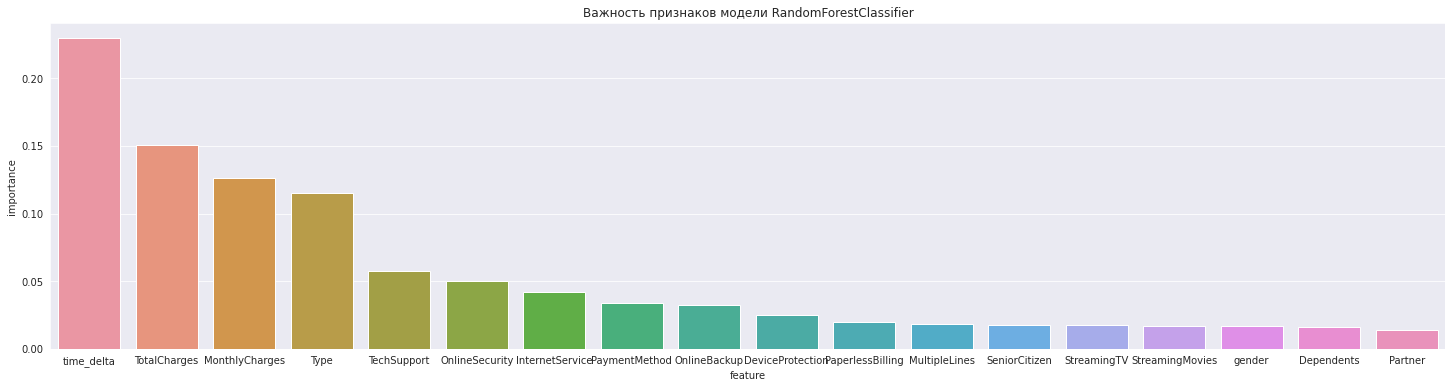

In [81]:
importance(model_rf_gr, features_train, 'RandomForestClassifier')

# Изменим набор признаков, оставим только самые важные для моделей

In [82]:
features_train_imp = features_train[['Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 
                        'OnlineSecurity', 'TechSupport', 'time_delta']]
features_train_imp.shape

(4225, 7)

In [83]:
features_valid_imp = features_valid[['Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 
                        'OnlineSecurity', 'TechSupport', 'time_delta']]
features_valid_imp.shape

(1409, 7)

In [84]:
model_rf_gr.fit(features_train_imp, target_train)
predicted_valid = model_rf_gr.predict(features_valid_imp)
accuracy = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_rf_gr.predict_proba(features_valid_imp)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_rf_imp = roc_auc_score(target_valid, probabilities_one_valid)

print('RandomForestClassifier (features_important): accuracy = {:.2f}'.format(accuracy))
print('RandomForestClassifier (features_important): roc_auc = {:.2f}'.format(roc_auc_rf_imp))

RandomForestClassifier (features_important): accuracy = 0.82
RandomForestClassifier (features_important): roc_auc = 0.87


### LGBMClassifier

In [85]:
model_lgbm = LGBMClassifier(metric="roc_auc", n_estimators=10, class_weight='balanced')

model_lgbm.fit(features_train, target_train)
predicted_valid = model_lgbm.predict(features_valid)
accuracy_lgbm = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_lgbm.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_lgbm = roc_auc_score(target_valid, probabilities_one_valid)

print('LGBMClassifier: accuracy = {:.2f}'.format(accuracy_lgbm))
print('LGBMClassifier: roc_auc = {:.2f}'.format(roc_auc_lgbm))

LGBMClassifier: accuracy = 0.77
LGBMClassifier: roc_auc = 0.86


In [86]:
model_lgbm.fit(features_upsampled, target_upsampled)
predicted_valid = model_lgbm.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_lgbm.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

print('LGBMClassifier (upsample): accuracy = {:.2f}'.format(accuracy))
print('LGBMClassifier (upsample): roc_auc = {:.2f}'.format(roc_auc))

LGBMClassifier (upsample): accuracy = 0.78
LGBMClassifier (upsample): roc_auc = 0.86


На увеличенной выборке целевая метрика не изменилась

# Подбираем гиперпараметры

In [87]:
model_lgbm_gr = LGBMClassifier()
parametrs_lgbm = {
    'n_estimators': [10, 50, 100],
    'max_depth' : [10, 15],
    'random_state': [12345]
}
grid_lgbm = GridSearchCV(model_lgbm_gr, param_grid=parametrs_lgbm, cv=3, scoring='roc_auc')

In [88]:
grid_lgbm.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'max_depth': [10, 15], 'n_estimators': [10, 50, 100],
                         'random_state': [12345]},
             scoring='roc_auc')

In [89]:
print(grid_lgbm.best_params_)

print('roc_auc = {:.2f}'.format(grid_lgbm.best_score_))

{'max_depth': 15, 'n_estimators': 50, 'random_state': 12345}
roc_auc = 0.87


# Важность признаков

In [90]:
model_lgbm_gr = LGBMClassifier(
    metric="roc_auc", 
    n_estimators=grid_lgbm.best_params_['n_estimators'], 
    max_depth=grid_lgbm.best_params_['max_depth'], 
    random_state=12345)

model_lgbm_gr.fit(features_train, target_train)

LGBMClassifier(max_depth=15, metric='roc_auc', n_estimators=50,
               random_state=12345)

,feature,importance
0,time_delta,505
1,MonthlyCharges,284
2,TotalCharges,246
3,PaymentMethod,60
4,MultipleLines,46


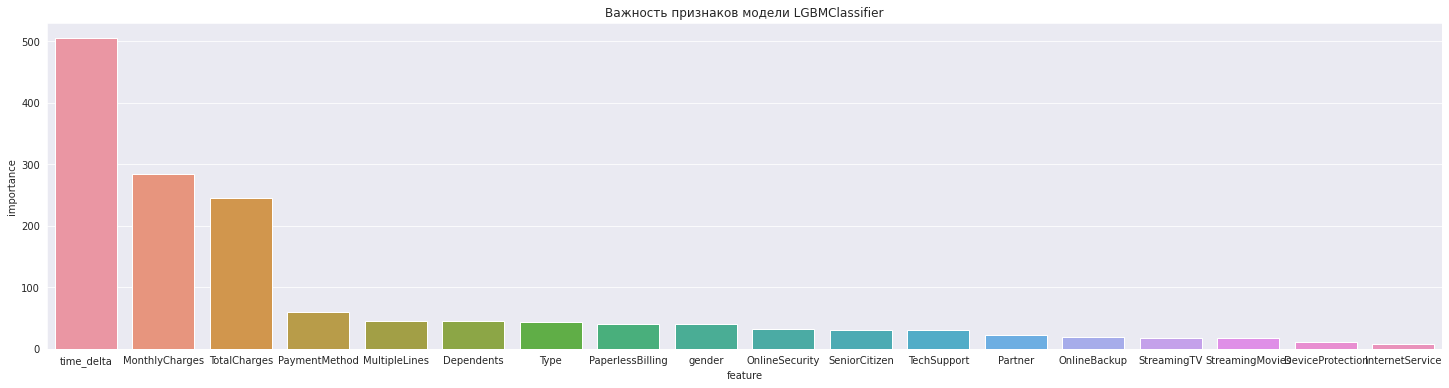

In [91]:
importance(model_lgbm_gr, features_train, 'LGBMClassifier')

In [92]:
model_lgbm_gr.fit(features_train_imp, target_train)
predicted_valid = model_lgbm_gr.predict(features_valid_imp)
accuracy = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_lgbm_gr.predict_proba(features_valid_imp)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_lgbm_imp = roc_auc_score(target_valid, probabilities_one_valid)

print('LGBMClassifier (features_important): accuracy = {:.2f}'.format(accuracy))
print('LGBMClassifier (features_important): roc_auc = {:.2f}'.format(roc_auc_lgbm_imp))

LGBMClassifier (features_important): accuracy = 0.84
LGBMClassifier (features_important): roc_auc = 0.88


### CatBoostClassifier

In [93]:
model_cbc = CatBoostClassifier(eval_metric='AUC', iterations=10, verbose=10)

categorical=[]

model_cbc.fit(features_train, target_train, cat_features=categorical)
predicted_valid = model_cbc.predict(features_valid)
accuracy_cbc = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_cbc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_cbc = roc_auc_score(target_valid, probabilities_one_valid)

print('CatBoostClassifier: accuracy = {:.2f}'.format(accuracy_cbc))
print('CatBoostClassifier: roc_auc = {:.2f}'.format(roc_auc_cbc))

Learning rate set to 0.5
0:	total: 47.6ms	remaining: 428ms
9:	total: 62.5ms	remaining: 0us
CatBoostClassifier: accuracy = 0.81
CatBoostClassifier: roc_auc = 0.86


In [94]:
model_cbc.fit(features_upsampled, target_upsampled, cat_features=categorical)
predicted_valid = model_cbc.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_cbc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

print('CatBoostClassifier (upsample): accuracy = {:.2f}'.format(accuracy))
print('CatBoostClassifier (upsample): roc_auc = {:.2f}'.format(roc_auc))

Learning rate set to 0.5
0:	total: 2.09ms	remaining: 18.8ms
9:	total: 20.3ms	remaining: 0us
CatBoostClassifier (upsample): accuracy = 0.76
CatBoostClassifier (upsample): roc_auc = 0.86


На увеличенной выборке колчество правильных ответов в общей массе вопросов снизилось (метрика accuracy), при это целевая метрика не изменилась

# Подбираем гиперпараметры

In [95]:
model_cbc_gr = CatBoostClassifier()
parametrs_cbc = {
    'iterations': [10, 50, 100],
    'max_depth' : [10, 15],
    'random_state': [12345],
    'verbose' : [50]
}
grid_cbc = GridSearchCV(model_cbc_gr, param_grid=parametrs_cbc, cv=3, scoring='roc_auc')

In [96]:
grid_cbc.fit(features_train, target_train)

Learning rate set to 0.5
0:	learn: 0.5413382	total: 1.65ms	remaining: 14.8ms
9:	learn: 0.3452223	total: 71.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5440419	total: 3.62ms	remaining: 32.6ms
9:	learn: 0.3430330	total: 67.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5519348	total: 8.48ms	remaining: 76.3ms
9:	learn: 0.3448237	total: 52.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5413382	total: 1.94ms	remaining: 17.5ms
9:	learn: 0.3219670	total: 9.7ms	remaining: 4.85ms
Learning rate set to 0.5
0:	learn: 0.5440419	total: 3.37ms	remaining: 30.3ms
9:	learn: 0.3247386	total: 10.9ms	remaining: 13.7ms
Learning rate set to 0.5
0:	learn: 0.5683290	total: 58.8ms	remaining: 529ms
9:	learn: 0.3134348	total: 2.79s	remaining: 0us
Learning rate set to 0.250018
0:	learn: 0.6060508	total: 1.49ms	remaining: 72.9ms
49:	learn: 0.2789797	total: 336ms	remaining: 0us
Learning rate set to 0.250056
0:	learn: 0.6084832	total: 2.9ms	remaining: 142ms
49:	learn: 0.2822633	total: 31

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f33728be970>,
             param_grid={'iterations': [10, 50, 100], 'max_depth': [10, 15],
                         'random_state': [12345], 'verbose': [50]},
             scoring='roc_auc')

In [97]:
print(grid_cbc.best_params_)

print('roc_auc = {:.2f}'.format(grid_cbc.best_score_))

{'iterations': 100, 'max_depth': 10, 'random_state': 12345, 'verbose': 50}
roc_auc = 0.86


# Важность признаков

In [98]:
model_cbc_gr = CatBoostClassifier(
    eval_metric='AUC', 
    iterations=grid_cbc.best_params_['iterations'],
    max_depth=grid_cbc.best_params_['max_depth'],
    verbose=10)

model_cbc_gr.fit(features_train, target_train)

Learning rate set to 0.157457
0:	total: 1.08ms	remaining: 107ms
10:	total: 70.6ms	remaining: 571ms
20:	total: 147ms	remaining: 552ms
30:	total: 202ms	remaining: 450ms
40:	total: 274ms	remaining: 394ms
50:	total: 333ms	remaining: 320ms
60:	total: 408ms	remaining: 261ms
70:	total: 484ms	remaining: 198ms
80:	total: 559ms	remaining: 131ms
90:	total: 639ms	remaining: 63.2ms
99:	total: 715ms	remaining: 0us


,feature,importance
0,time_delta,20.59
1,Type,13.01
2,InternetService,6.24
3,MonthlyCharges,5.75
4,OnlineSecurity,5.50


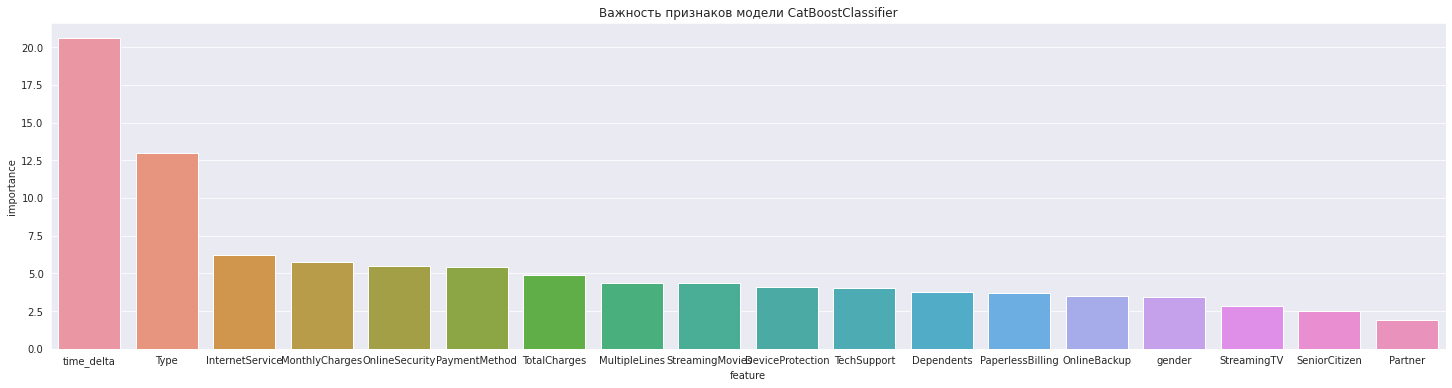

In [99]:
importance(model_cbc_gr, features_train, 'CatBoostClassifier')

In [100]:
model_cbc_gr.fit(features_train_imp, target_train)
predicted_valid = model_cbc_gr.predict(features_valid_imp)
accuracy = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_cbc_gr.predict_proba(features_valid_imp)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_cbc_imp = roc_auc_score(target_valid, probabilities_one_valid)

print('CatBoostClassifier (features_important): accuracy = {:.2f}'.format(accuracy))
print('CatBoostClassifier (features_important): roc_auc = {:.2f}'.format(roc_auc_cbc_imp))

Learning rate set to 0.157457
0:	total: 7.01ms	remaining: 694ms
10:	total: 37.7ms	remaining: 305ms
20:	total: 80.6ms	remaining: 303ms
30:	total: 130ms	remaining: 289ms
40:	total: 177ms	remaining: 255ms
50:	total: 240ms	remaining: 230ms
60:	total: 303ms	remaining: 194ms
70:	total: 371ms	remaining: 151ms
80:	total: 439ms	remaining: 103ms
90:	total: 506ms	remaining: 50.1ms
99:	total: 570ms	remaining: 0us
CatBoostClassifier (features_important): accuracy = 0.84
CatBoostClassifier (features_important): roc_auc = 0.89


### DummyClassifier

In [101]:
model_dm = DummyClassifier(strategy='prior')
model_dm.fit(features_train, target_train)
predicted_valid = model_dm.predict(features_valid)
accuracy_dm = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_dm.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_dm = roc_auc_score(target_valid, probabilities_one_valid)

print('DummyClassifier: accuracy = {:.2f}'.format(accuracy_dm))
print('DummyClassifier: roc_auc = {:.2f}'.format(roc_auc_dm))

DummyClassifier: accuracy = 0.73
DummyClassifier: roc_auc = 0.50


In [102]:
model_dm.fit(features_train_imp, target_train)
predicted_valid = model_dm.predict(features_valid_imp)
accuracy = accuracy_score(target_valid, predicted_valid)

probabilities_valid = model_dm.predict_proba(features_valid_imp)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_dm_imp = roc_auc_score(target_valid, probabilities_one_valid)

print('DummyClassifier (features_important): accuracy = {:.2f}'.format(accuracy))
print('DummyClassifier (features_important): roc_auc = {:.2f}'.format(roc_auc_dm_imp))

DummyClassifier (features_important): accuracy = 0.73
DummyClassifier (features_important): roc_auc = 0.50


### Итоги

In [103]:
values_models_valid = pd.DataFrame([
    ['RandomForestClassifier', grid_forest.best_score_, roc_auc_rf_imp, 'valid'],
    ['LGBMClassifier', grid_lgbm.best_score_, roc_auc_lgbm_imp, 'valid'],
    ['CatBoostClassifier',grid_cbc.best_score_, roc_auc_cbc_imp, 'valid'],
    ['DummyClassifier', roc_auc_dm, roc_auc_dm_imp,'valid']
],
    columns=['Model', 'Roc_Auc','Roc_Auc_important', 'Feature']
)
values_models_valid

,Model,Roc_Auc,Roc_Auc_important,Feature
0,RandomForestClassifier,0.86,0.87,valid
1,LGBMClassifier,0.87,0.88,valid
2,CatBoostClassifier,0.86,0.89,valid
3,DummyClassifier,0.50,0.50,valid


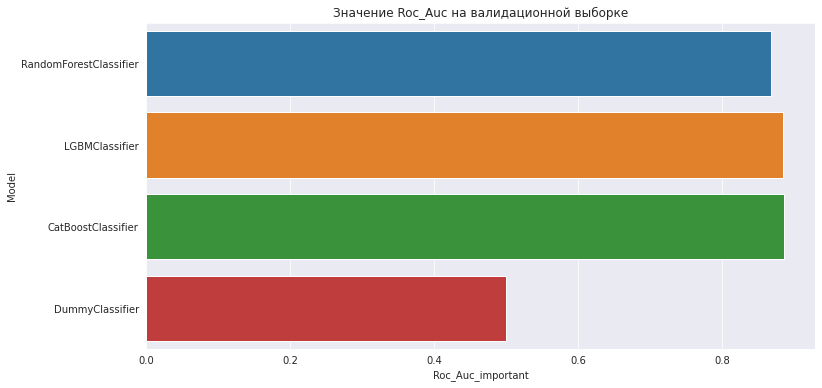

In [104]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.barplot(x='Roc_Auc_important', y='Model', data=values_models_valid)
plt.title('Значение Roc_Auc на валидационной выборке')

plt.show()

### Вывод:  
Все обученные модели показали приблизительно одинаковый результат, который превзошел результат случайной модели

## Тестирование моделей

Объединим выборки для возможности обучения модели на бОльшей выборке

In [105]:
df_features = pd.concat([features_train_imp] + [features_valid_imp])

df_features.shape

(5634, 7)

In [106]:
df_target = pd.concat([target_train] + [target_valid])

df_target.shape

(5634,)

In [107]:
features_test_imp = features_test[['Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 
                        'OnlineSecurity', 'TechSupport', 'time_delta']]
features_test_imp.shape

(1409, 7)

Функция по тестированию моделей:
- принимает на вход модель, обучающую выборку, тестовую выборку, название модели)
- рассчитывает и выводиит _accuracy, roc_auc_, confusion_matrix__
- строит Roc-кривую _roc_curve_
- выводит таблицу (топ 5) и график важности признаков в модели

In [108]:
def test(model, features_train, target_train, features_test, target_test, model_name):
    model.fit(features_train, target_train)
    predicted_test = model.predict(features_test)
    accuracy = accuracy_score(target_test, predicted_test)

    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    roc_auc = roc_auc_score(target_test, probabilities_one_test)

    print(model_name, ': accuracy = {:.2f}'.format(accuracy))
    print(model_name, ': roc_auc = {:.2f}'.format(roc_auc))
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr)
    # plt.step(fpr, tpr, where='post')
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Доля ложноположительных предсказаний')
    plt.ylabel('Доля положительных ответов')
    plt.title('ROC-кривая ' + model_name)

    plt.show()
    
    matrix = confusion_matrix(target_test, predicted_test)
    print(matrix)
    print()
    recall = recall_score(target_test, predicted_test)
    precision = precision_score(target_test, predicted_test)
    print(model_name, ': recall = {:.2f}'.format(recall))
    print(model_name, ': precision = {:.2f}'.format(precision))
    
    precision_plot, recall_plot, thresholds = precision_recall_curve(target_test, probabilities_one_test)

    plt.figure(figsize=(6, 6))
    plt.plot(recall_plot, precision_plot)
    plt.xlabel('Полнота')
    plt.ylabel('Точность')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Точность - Полнота')
    plt.show() 

    try:
        print()
        importances = model.feature_importances_
        feature_list = list(features_train.columns)
        feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

        feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)
        display(feature_results.head())

        plt.figure(figsize=(25,6))
        sns.set_style('darkgrid')
        sns.barplot(x='feature', y='importance', data=feature_results)
        plt.title('Важность признаков модели '+ model_name)

        plt.show()
    except:
        None
    
    return roc_auc, accuracy, recall, precision

### RandomForestClassifier

In [109]:
model_rf_gr = RandomForestClassifier(
    n_estimators=grid_forest.best_params_['n_estimators'], 
    max_depth=grid_forest.best_params_['max_depth'],
    random_state=12345)

RandomForestClassifier : accuracy = 0.81
RandomForestClassifier : roc_auc = 0.85


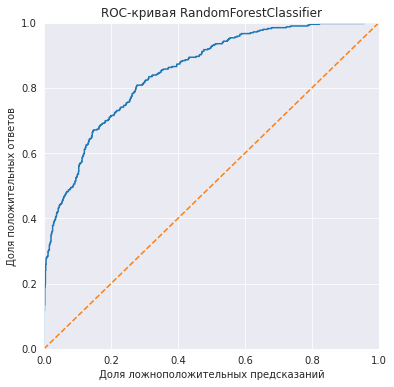

[[955  68]
 [201 185]]

RandomForestClassifier : recall = 0.48
RandomForestClassifier : precision = 0.73


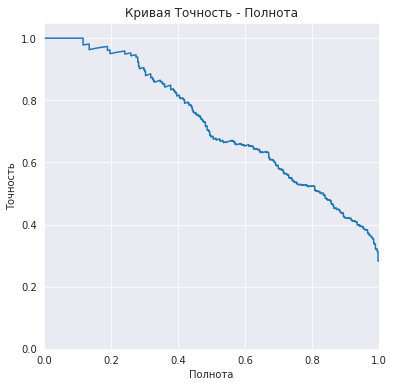

,feature,importance
0,time_delta,0.27
1,MonthlyCharges,0.19
2,TotalCharges,0.19
3,Type,0.14
4,TechSupport,0.09


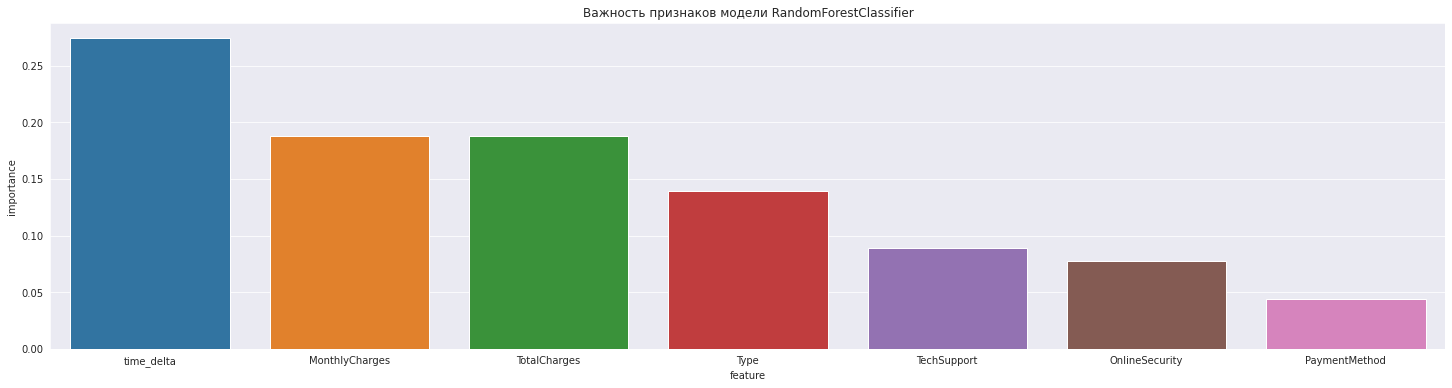

In [110]:
test_roc_auc_rf, test_accuracy_rf, test_recall_rf, test_precision_rf  = test(
    model_rf_gr, 
    df_features, 
    df_target, 
    features_test_imp, 
    target_test, 
    'RandomForestClassifier')

### LGBMClassifier

In [111]:
model_lgbm_gr = LGBMClassifier(
    metric="roc_auc", 
    n_estimators=grid_lgbm.best_params_['n_estimators'], 
    max_depth=grid_lgbm.best_params_['max_depth'], 
    random_state=12345)

LGBMClassifier : accuracy = 0.84
LGBMClassifier : roc_auc = 0.89


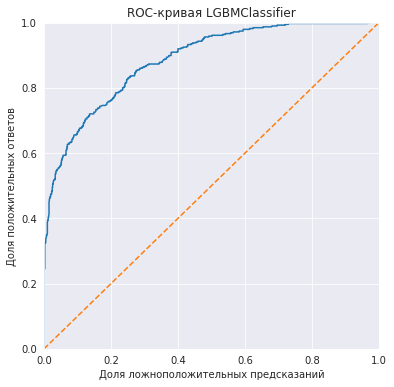

[[971  52]
 [168 218]]

LGBMClassifier : recall = 0.56
LGBMClassifier : precision = 0.81


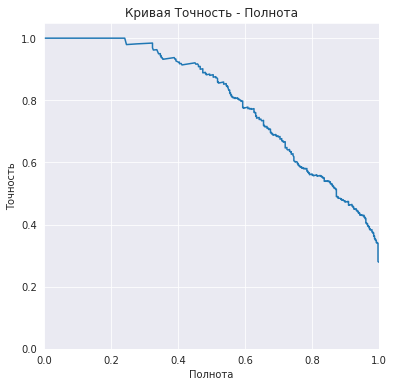

,feature,importance
0,time_delta,658
1,MonthlyCharges,361
2,TotalCharges,269
3,PaymentMethod,71
4,Type,57


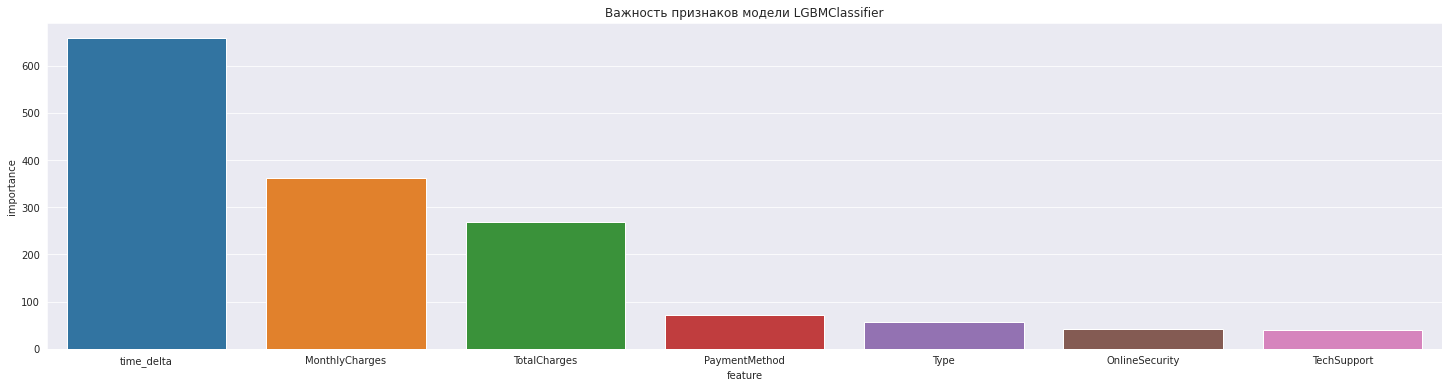

In [112]:
test_roc_auc_lgbm, test_accuracy_lgbm, test_recall_lgbm, test_precision_lgbm  = test(
    model_lgbm_gr, 
    df_features, 
    df_target, 
    features_test_imp, 
    target_test, 
    'LGBMClassifier')

### CatBoostClassifier

In [113]:
model_cbc_gr = CatBoostClassifier(
    eval_metric='AUC', 
    iterations=grid_cbc.best_params_['iterations'],
    max_depth=grid_cbc.best_params_['max_depth'],
    verbose=10)

Learning rate set to 0.178046
0:	total: 7.56ms	remaining: 748ms
10:	total: 57.3ms	remaining: 464ms
20:	total: 112ms	remaining: 422ms
30:	total: 169ms	remaining: 376ms
40:	total: 230ms	remaining: 331ms
50:	total: 293ms	remaining: 282ms
60:	total: 366ms	remaining: 234ms
70:	total: 438ms	remaining: 179ms
80:	total: 510ms	remaining: 120ms
90:	total: 581ms	remaining: 57.5ms
99:	total: 646ms	remaining: 0us
CatBoostClassifier : accuracy = 0.84
CatBoostClassifier : roc_auc = 0.87


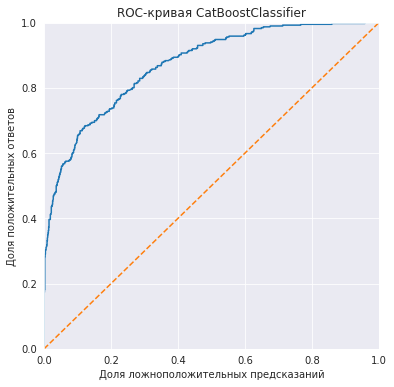

[[970  53]
 [173 213]]

CatBoostClassifier : recall = 0.55
CatBoostClassifier : precision = 0.80


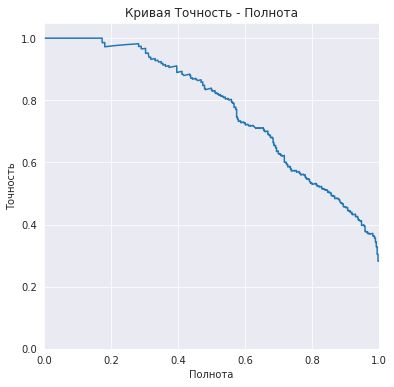

,feature,importance
0,time_delta,39.34
1,MonthlyCharges,15.33
2,Type,13.91
3,PaymentMethod,9.60
4,TotalCharges,8.37


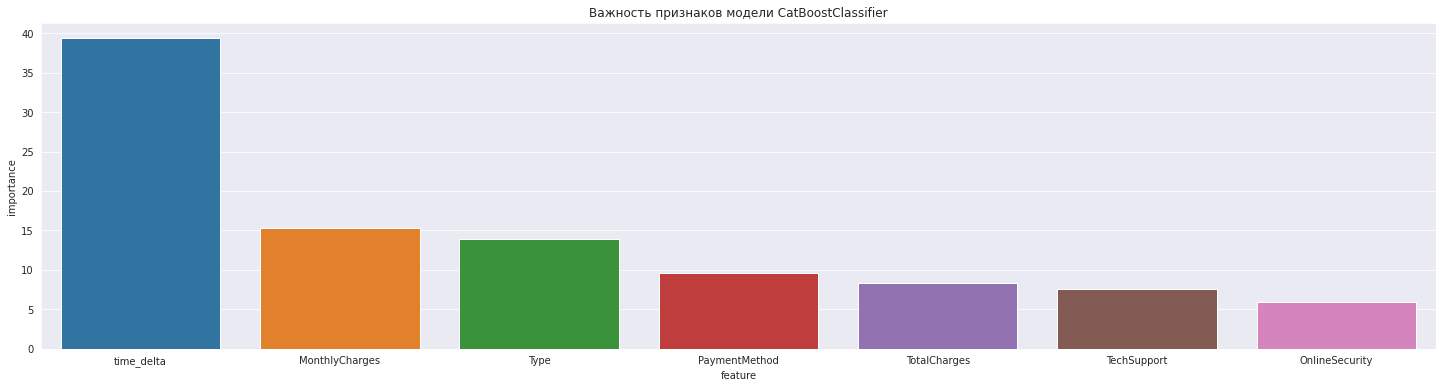

In [114]:
test_roc_auc_cbc, test_accuracy_cbc, test_recall_cbc, test_precision_cbc  = test(
    model_cbc_gr, 
    df_features, 
    df_target, 
    features_test_imp, 
    target_test, 
    'CatBoostClassifier')

### DummyClassifier

DummyClassifier : accuracy = 0.73
DummyClassifier : roc_auc = 0.50


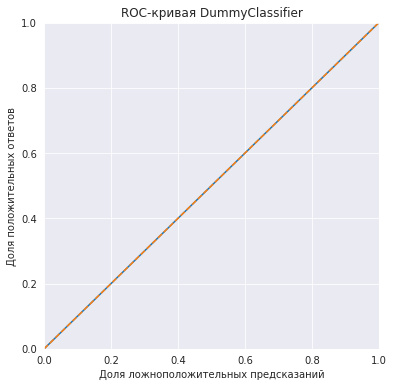

[[1023    0]
 [ 386    0]]

DummyClassifier : recall = 0.00
DummyClassifier : precision = 0.00


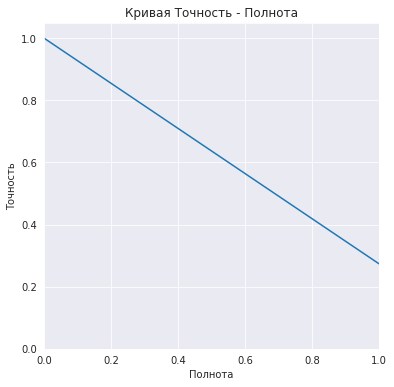

In [115]:
test_roc_auc_dm, test_accuracy_dm, test_recall_dm, test_precision_dm  = test(
    model_dm, 
    df_features, 
    df_target, 
    features_test_imp, 
    target_test, 
    'DummyClassifier')

### Итоги

In [116]:
values_models_test = pd.DataFrame([
    ['RandomForestClassifier', test_roc_auc_rf, test_accuracy_rf, test_recall_rf, test_precision_rf, 'test'],
    ['LGBMClassifier', test_roc_auc_lgbm, test_accuracy_lgbm, test_recall_lgbm, test_precision_lgbm, 'test'],
    ['CatBoostClassifier',test_roc_auc_cbc,test_accuracy_cbc, test_recall_cbc, test_precision_cbc, 'test'],
    ['DummyClassifier', test_roc_auc_dm, test_accuracy_dm, test_recall_dm, test_precision_dm, 'test']
],
    columns=['Model', 'Roc_Auc_important', 'Accuracy', 'Recall', 'Precision', 'Feature']
)
values_models_test

,Model,Roc_Auc_important,Accuracy,Recall,Precision,Feature
0,RandomForestClassifier,0.85,0.81,0.48,0.73,test
1,LGBMClassifier,0.89,0.84,0.56,0.81,test
2,CatBoostClassifier,0.87,0.84,0.55,0.80,test
3,DummyClassifier,0.50,0.73,0.00,0.00,test


In [117]:
values_models = pd.concat([values_models_valid] + [values_models_test])

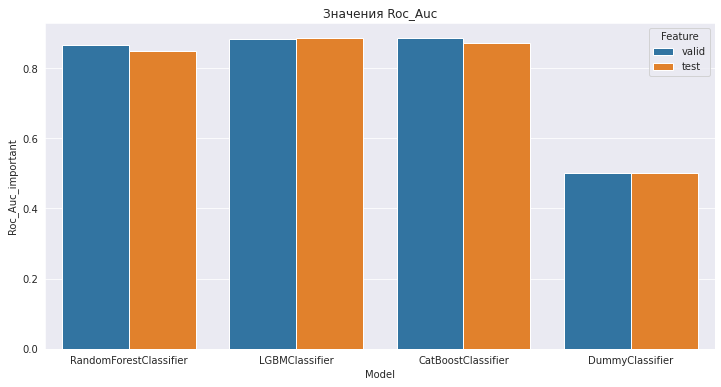

In [118]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.barplot(x='Model', y='Roc_Auc_important', data=values_models, hue='Feature')
plt.title('Значения Roc_Auc')


plt.show()

In [119]:
values_models_new = values_models_valid[['Model', 'Roc_Auc_important']].merge(
    values_models_test[['Model', 'Roc_Auc_important', 'Accuracy', 'Recall', 'Precision']], on=['Model'], how='left')
values_models_new.set_axis([
    'Model', 'Roc_Auc_valid', 'Roc_Auc_test','Accuracy_test', 'Recall_test', 'Precision_test'
], axis='columns', inplace=True)
values_models_new

,Model,Roc_Auc_valid,Roc_Auc_test,Accuracy_test,Recall_test,Precision_test
0,RandomForestClassifier,0.87,0.85,0.81,0.48,0.73
1,LGBMClassifier,0.88,0.89,0.84,0.56,0.81
2,CatBoostClassifier,0.89,0.87,0.84,0.55,0.80
3,DummyClassifier,0.50,0.50,0.73,0.00,0.00


## Вывод

1. получили 4 файла с целью предсказания оттока клиентов оператора связи «Ниединогоразрыва.ком» (метрика auc_roc)
2. привели к корректным форматам данные, объединили таблицы, заменили пропущенные значения с целью сохранения информации, так как объем данных небольшой
3. провели исследовательский анализ данных, выяснили, что месячные расходы клиентов снижаются из года в год, чаще остальных клиенты используют дополнительные опции: стримминговые фильмы и телевидение
4. разметили целевую метрику, добавили признак количества дней между начальной и конечной датами пользования услугами Заказчика
5. закодировали категориальные признаки
6. балансировали выборку за счет увеличения реже встречающегося класса 1, однако, значительного улучшения метрики это не дало
7. порядок числовых параметров несильно расходится, поэтому не масштабировали признаки
8. обучили 3 модели: RandomForestClassifier, LGBMClassifier, CatBoostClassifier
9. перебрали гиперпараметры с помощью GridSearchCV, при кросс-валидации все модели показали схожий результат, который значительно превзошел результат константной модели
10. однако, на тестовой выборке лучший результат показала модель LGBMClassifier, как в целевой метрике, так и в точности и полноте
11. модели показали на обеих выборках схожий результат метрики, что говорит о том, что они не переобучились на тренировочной выборке
12. у всех моделей важнейшим признаком оказался добавленный признак "срока жизни" клиента, также были важны общий и месячные расходы клиентов (до удаления столбца _начальная дата_, на втором месте после признака "срок жизни клиента" был именно этот признак)